## 9.4.1 统计分析

我们这一节要讲的统计分析主要是针对文本的。在9.2节中，我们针对《越女剑》数据集，构建除出了词表。利用词表我们可以挖掘出很多信息。比如，我们可以打印出词频排名最为考前的一些词。我们先把读取数据集并构建词表的代码执行一下。

In [1]:
import random
import torch
import string
from zhon.hanzi import punctuation

with open('data/越女剑.txt', 'r') as f:
    lines = f.readlines()
exclude = set(punctuation)
lines = [ ''.join(ch for ch in line if ch not in exclude).replace('\n','') for line in lines]
tokens = [list(line) for line in lines ]

import collections

class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

vocab = Vocab(tokens)

然后我们利用词表来打印出排名前10的词。

In [2]:
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
vocab.token_freqs[:10]

[('剑', 395),
 ('的', 289),
 ('一', 260),
 ('不', 205),
 ('道', 202),
 ('士', 195),
 ('是', 192),
 ('了', 174),
 ('人', 155),
 ('范', 138)]

可以看到，排名前10的词中，有一些没什么意义的词，比如“的”、“了”等等，这些就是我们前面讲过的停用词了。接下来我们可以绘制出词频图，来更清楚地看到词频分布。

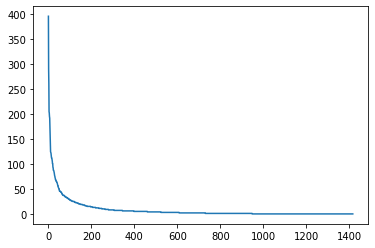

In [12]:
import matplotlib.pyplot as plt
import math
freqs = [freq for token, freq in vocab.token_freqs]
plt.plot(freqs)

### 9.4.1.1 长尾分布

可以看到词频分布出现了长尾分布。长尾分布是指在数据分布中，极少数的数据占据了大部分的位置，而大多数的数据只占据了极少的位置，这种分布状态被称为长尾分布。

长尾分布常见于数据中的搜索结果，例如在搜索引擎中，极少数的搜索结果会被大量访问，而大多数的搜索结果只会被很少访问。在自然语言领域，相对于前面的高频词，这些长尾反而更加重要。因此在计算中，会考虑去除前面高频停用词，或者用一些方法来降低高频特征权重，提升低频特征和未见过特征的权重，比如前面讲过的平滑方法。

### 9.4.1.2 齐夫定律

除了长尾分布，还有一种鼎鼎大名的词频分布规律，叫齐夫定律。

齐夫定律，也叫Zipf定律，是由哈佛大学的语言学家乔治·金斯利·齐夫（George Kingsley Zipf）于1949年发表的实验定律。它是一种语言学定理，它指出在自然语言中，一个单词出现的频率与其在词汇表中的排名成反比例。频率最高的单词出现的频率大约是出现频率第二位的单词的2倍，而出现频率第二位的单词则是出现频率第四位的单词的2倍。这个定律被作为任何与幂定律概率分布有关的事物的参考。

我们把刚刚的词频曲线的坐标轴设置为对数坐标，来看一下结果。

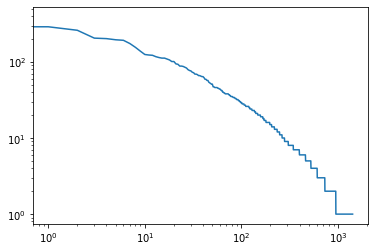

In [20]:
fig, ax = plt.subplots()
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
plt.plot(freqs)

可以看到词频曲线基本趋近于双对数坐标图上的一条直线。单个词的词频分析，相当于一元语法，我们再来看看多元的情况如何。

In [21]:
# 二元语法词频
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('剑', '士'), 134),
 (('范', '蠡'), 117),
 (('阿', '青'), 62),
 (('吴', '国'), 53),
 (('青', '衣'), 47),
 (('勾', '践'), 47),
 (('衣', '剑'), 46),
 (('锦', '衫'), 40),
 (('衫', '剑'), 40),
 (('长', '剑'), 36)]

In [22]:
# 三元语法词频
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('青', '衣', '剑'), 46),
 (('衣', '剑', '士'), 46),
 (('锦', '衫', '剑'), 40),
 (('衫', '剑', '士'), 40),
 (('国', '剑', '士'), 27),
 (('伍', '子', '胥'), 23),
 (('吴', '国', '剑'), 20),
 (('名', '青', '衣'), 18),
 (('范', '蠡', '道'), 18),
 (('那', '少', '女'), 18)]

我们用一张图来看一下不同语法分布的规律。

[]

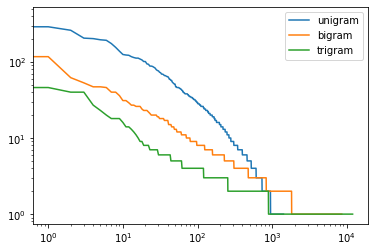

In [24]:
unigram_freqs = [freq for token, freq in vocab.token_freqs]
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
fig, ax = plt.subplots()
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
plt.plot(unigram_freqs, label='unigram')
plt.plot(bigram_freqs, label='bigram')
plt.plot(trigram_freqs, label='trigram')
plt.legend()
plt.plot()

可以看到，除了基本上多元语法模型同样遵循齐夫定律，并且随着n元模型的n的增大啊，曲线越发平缓了。但是同时，随着n的增加，越来越多的ngram出现的越来越少，这让我们使用传统方法进行建模难度越来越大。也为深度学习的引入创造了机会。

## 9.4.2 数据集构造

和前面讲过的图像分类等模型不同，文本数据并没有标签，因此为了能够训练出模型，需要我们手动构造出带标签的数据集。还记得9.1节中，我们学习的时间序列建模吗？那时候，我们也是手动构造的训练数据集，用前t-n+1个元素作为输入X，第t个元素作为输出y。然后定义一个偏移量offset，最后就是遍历全部数据去构造数据集了。这里我们写好了相关代码，并封装成了一个DataLoader类，可以在后续训练中迭代取出训练数据。

In [ ]:
class DataLoader:
    def __init__(self):
        self.corpus = corpus  ##全部语料list
        self.batch_size = batch_size  ##批量大小
        self.num_steps = num_steps    ##
    
    def __iter__(self):
        ## 设置随机偏移量
        offset = random.randint(0, num_steps)
        num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
        Xs = torch.tensor(corpus[offset: offset + num_tokens])
        Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
        Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
        num_batches = Xs.shape[1] // num_steps
        for i in range(0, num_steps * num_batches, num_steps):
            X = Xs[:, i: i + num_steps]
            Y = Ys[:, i: i + num_steps]
            yield X, Y

在下一节的循环神经网络模型代码部分，我们将使用这个DataLoader类来构造数据集。

**梗直哥提示：本节我们学习了文本数据的统计分析方法和数据集构造方法，。更加详细的知识点的掌握，有赖于你在实战中总结经验，慢慢就熟悉了。当然，如果你想大幅节省时间，解答自己在学习中的各种困惑，欢迎选修《梗直哥深度学习：python实战》。**